In [5]:


# # Plotting the Reward Structures
# def plot_reward_structures():
#     x_range = np.linspace(-10, 10, 100)
#     y_range = np.linspace(-10, 10, 100)
#     boundary_limits = (-10, 10, -10, 10)  # Boundary box
#     goal = [4, 6]
    
#     # Randomly select a starting position within the boundary limits
#     starting_position = np.random.uniform(low=-9, high=9, size=2)

#     # Create a mesh grid for the state space
#     X, Y = np.meshgrid(x_range, y_range)
#     Z = np.zeros(X.shape)

#     # Calculate rewards over the entire state space
#     previous_state = starting_position
#     for i in range(X.shape[0]):
#         for j in range(X.shape[1]):
#             state = [X[i, j], Y[i, j]]
#             Z[i, j] = combined_reward(state, goal, previous_state, boundary_limits)
#             previous_state = state

#     # Plotting the surface
#     plt.figure(figsize=(12, 8))
#     plt.contourf(X, Y, Z, levels=np.linspace(-100, 20, 100), cmap='RdYlBu')
#     plt.colorbar(label='Total Reward')
#     plt.scatter(goal[0], goal[1], color='black', marker='x', s=100, label='Goal')
#     plt.scatter(starting_position[0], starting_position[1], color='green', marker='o', s=100, label='Starting Position')
#     plt.title("Reward Structure for Navigation Task")
#     plt.xlabel("X Position")
#     plt.ylabel("Y Position")
#     plt.legend()
#     plt.grid()
#     plt.ylim(-10, 10)
#     plt.xlim(-10, 10)
#     plt.show()

# # Execute the plot function to visualize the reward structures
# plot_reward_structures()


In [64]:
import numpy as np
import matplotlib.pyplot as plt

def hard_crash_penalty():
    """Return a hard penalty for crashing."""
    return -100

def reward_for_direction(state, previous_state, goal):
    """Compute direction reward based on cosine similarity."""
    vector_to_goal = np.array(goal) - np.array(state)
    vector_action = np.array(state) - np.array(previous_state)
    cosine_similarity = np.dot(vector_to_goal, vector_action) / (np.linalg.norm(vector_to_goal) * np.linalg.norm(vector_action) + 1e-9)
    return cosine_similarity

def scale_direction_reward(cosine_similarity, state, goal, max_distance, scale_factors = [5, 0.1]):
    """Diminish the importance of the direction reward when closer to the goal."""
    distance_to_goal = np.linalg.norm(np.array(goal) - np.array(state))
    distance_threshold = max_distance * 0.1
    # Diminishing factor should decrease reward as the agent gets closer
    if distance_to_goal > distance_threshold:  # Far from the goal
        scale_factor = scale_factors[0]  # Full reward when far
    else:  # Close to the goal
        scale_factor = scale_factors[1]

    scaled_direction_reward = cosine_similarity * scale_factor  # Adjust scaling factor as needed
    return scaled_direction_reward

def reward_for_distance(state, previous_state, goal):
    """Compute hybrid distance reward."""
    curr_distance_to_goal = np.linalg.norm(np.array(goal) - np.array(state))
    prev_distance_to_goal = np.linalg.norm(np.array(goal) - np.array(previous_state))
    return prev_distance_to_goal - curr_distance_to_goal

def scale_distance_reward(distance_reward, state, goal, max_distance_per_step, scale_factor_distance=20):
    """Reward larger steps when far from the goal and smaller, precise steps when close."""
    distance_to_goal = np.linalg.norm(np.array(goal) - np.array(state))
    
    # Logarithmic scaling applied throughout -- to encourage lage steps at distance; smaller close to goal
    scaling_factor_smoothing = np.log1p(distance_to_goal)
    
    scaled_distance_reward = scaling_factor_smoothing * (distance_reward/max_distance_per_step) * scale_factor_distance
    return np.clip(scaled_distance_reward, -5, 5)  # Clipped for more stable behavior

def smooth_crash_penalty(state, boundary_limits, threshold=1.5):
    """Compute a smooth crash penalty based on the distance to the nearest boundary."""
    x, y = state
    x_min, x_max, y_min, y_max = boundary_limits
    
    # Calculate the distance to the nearest boundary
    distances = [
        x - x_min,  # Distance to left boundary
        x_max - x,  # Distance to right boundary
        y - y_min,  # Distance to bottom boundary
        y_max - y   # Distance to top boundary
    ]
    
    # Find the minimum distance to a boundary
    min_distance = min(distances)
    
    # If the agent is within the threshold, apply a smooth penalty
    if min_distance < threshold:
        return -50 * (threshold - min_distance) / threshold
    else:
        return 0  # No penalty if outside the threshold


def combined_reward(state, goal, previous_state, boundary_limits, max_distance_per_step, max_distance):
    """
    Computes the combined reward with hard and smooth penalties, and reward shaping using a potential function.
    """

    # Check if the agent has crashed into the boundary
    crashed = check_boundary(state, boundary_limits)
    
    if crashed:
        return hard_crash_penalty()  # Apply hard penalty
    
    # Compute direction and distance rewards
    direction_reward = reward_for_direction(state, previous_state, goal)
    scaled_direction_reward = scale_direction_reward(direction_reward, state, goal, max_distance=max_distance)
    
    distance_reward = reward_for_distance(state, previous_state, goal)
    scaled_distance_reward = scale_distance_reward(distance_reward, state, goal, max_distance_per_step)
    
    # Compute smooth crash penalty
    smooth_penalty = smooth_crash_penalty(state, boundary_limits)
    
    # Weighted sum of rewards
    w1 = 1.0  # Weight for direction reward
    w2 = 1.0  # Weight for distance reward
    total_reward = w1 * scaled_direction_reward + w2 * scaled_distance_reward + smooth_penalty 
    
    # Clip total reward to desired range (optional)
    return np.clip(total_reward, -100, 20)

def check_boundary(state, boundary_limits):
    """Check if the agent is outside the boundary limits."""
    x, y = state
    x_min, x_max, y_min, y_max = boundary_limits
    return not (x_min <= x <= x_max and y_min <= y <= y_max)


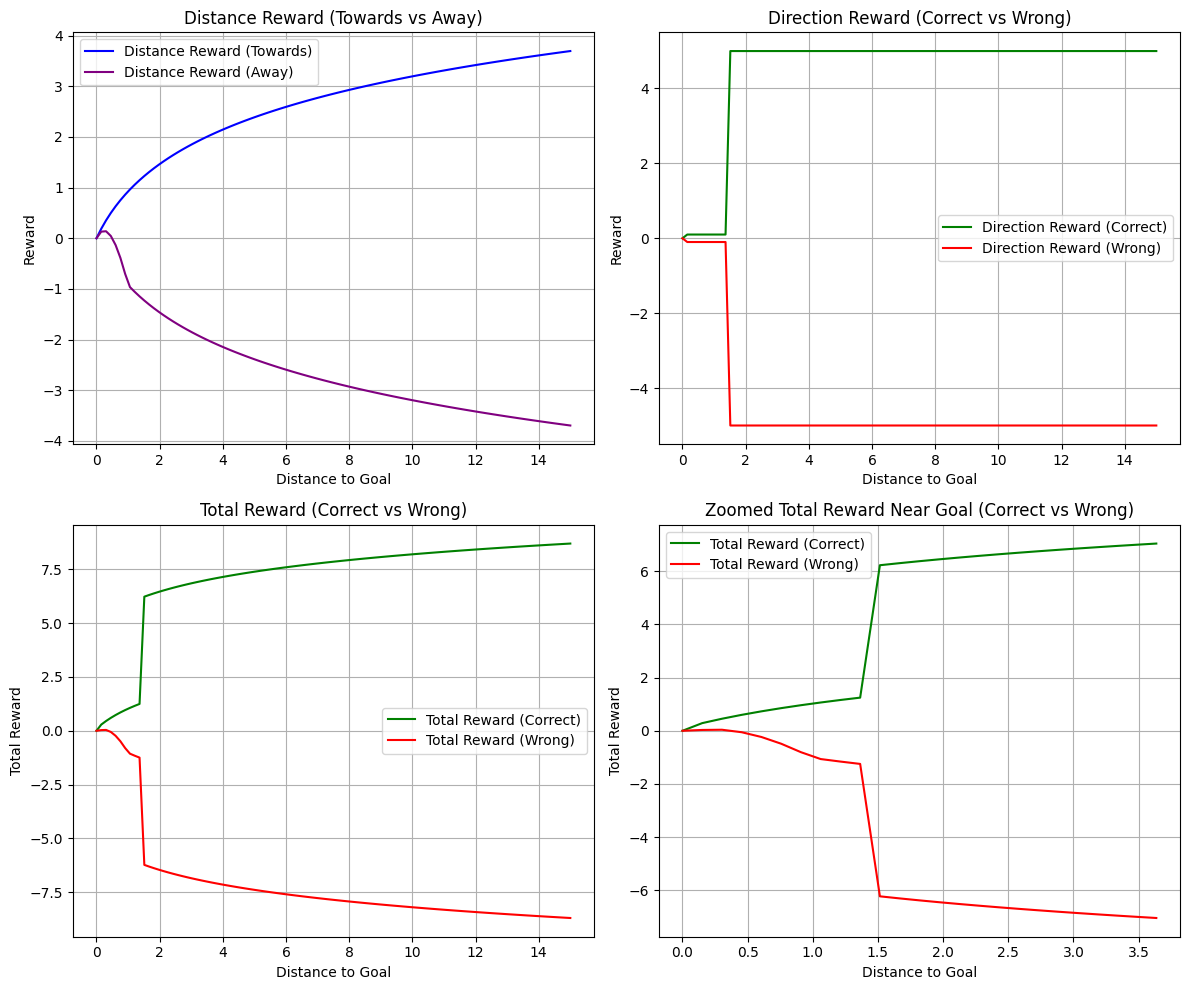

In [67]:
import numpy as np
import matplotlib.pyplot as plt
# Parameters
goal = np.array([0, 0])  # Assuming the goal is at the origin for simplicity
max_distance = 15  # Maximum distance to plot
max_distance_per_step = 5  # Maximum distance per step
# Function to generate a series of states at varying distances from the goal
def generate_states_at_distances(goal, max_distance):
    distances = np.linspace(0, max_distance, 100)  # 100 points between 0 and max_distance
    states = np.array([[d, 0] for d in distances])  # States along the x-axis
    return states, distances
# Simulate correct direction (cosine similarity ~ 1) and wrong direction (cosine similarity ~ -1)
def simulate_correct_and_wrong_direction(states, goal):
    previous_state_correct = states + np.array([1, 0])  # Moving toward goal (positive x direction)
    previous_state_wrong = states - np.array([1, 0])  # Moving away from goal (negative x direction)
    return previous_state_correct, previous_state_wrong
# Plotting function
def plot_rewards():
    # Generate states at different distances
    states, distances = generate_states_at_distances(goal, max_distance)
    previous_state_correct, previous_state_wrong = simulate_correct_and_wrong_direction(states, goal)
    # Calculate rewards for both correct and wrong directions
    direction_rewards_correct = [scale_direction_reward(reward_for_direction(s, ps, goal), s, goal, max_distance)
                                 for s, ps in zip(states, previous_state_correct)]
    direction_rewards_wrong = [scale_direction_reward(reward_for_direction(s, ps, goal), s, goal, max_distance)
                               for s, ps in zip(states, previous_state_wrong)]
    distance_rewards_towards = [scale_distance_reward(reward_for_distance(s, ps, goal), s, goal, max_distance)
                                for s, ps in zip(states, previous_state_correct)]  # Same for both directions
    distance_rewards_away = [scale_distance_reward(reward_for_distance(s, ps, goal), s, goal, max_distance)
                             for s, ps in zip(states, previous_state_wrong)]
    total_rewards_correct = np.array(direction_rewards_correct) + np.array(distance_rewards_towards)
    total_rewards_wrong = np.array(direction_rewards_wrong) + np.array(distance_rewards_away)
    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    # Distance reward (towards vs away)
    axs[0, 0].plot(distances, distance_rewards_towards, label='Distance Reward (Towards)', color='b')
    axs[0, 0].plot(distances, distance_rewards_away, label='Distance Reward (Away)', color='purple')
    axs[0, 0].set_title('Distance Reward (Towards vs Away)')
    axs[0, 0].set_xlabel('Distance to Goal')
    axs[0, 0].set_ylabel('Reward')
    axs[0, 0].legend()
    axs[0, 0].grid(True)
    # Cosine similarity rewards (correct direction)
    axs[0, 1].plot(distances, direction_rewards_correct, label='Direction Reward (Correct)', color='g')
    axs[0, 1].plot(distances, direction_rewards_wrong, label='Direction Reward (Wrong)', color='r')
    axs[0, 1].set_title('Direction Reward (Correct vs Wrong)')
    axs[0, 1].set_xlabel('Distance to Goal')
    axs[0, 1].set_ylabel('Reward')
    axs[0, 1].legend()
    axs[0, 1].grid(True)
    # Total rewards for moving towards and away
    axs[1, 0].plot(distances, total_rewards_correct, label='Total Reward (Correct)', color='g')
    axs[1, 0].plot(distances, total_rewards_wrong, label='Total Reward (Wrong)', color='r')
    axs[1, 0].set_title('Total Reward (Correct vs Wrong)')
    axs[1, 0].set_xlabel('Distance to Goal')
    axs[1, 0].set_ylabel('Total Reward')
    axs[1, 0].legend()
    axs[1, 0].grid(True)
    # Zoomed-in plot for total rewards near goal
    axs[1, 1].plot(distances[:25], total_rewards_correct[:25], label='Total Reward (Correct)', color='g')
    axs[1, 1].plot(distances[:25], total_rewards_wrong[:25], label='Total Reward (Wrong)', color='r')
    axs[1, 1].set_title('Zoomed Total Reward Near Goal (Correct vs Wrong)')
    axs[1, 1].set_xlabel('Distance to Goal')
    axs[1, 1].set_ylabel('Total Reward')
    axs[1, 1].legend()
    axs[1, 1].grid(True)
    # Display the plot
    plt.tight_layout()
    plt.show()
# Execute the plotting function
plot_rewards()

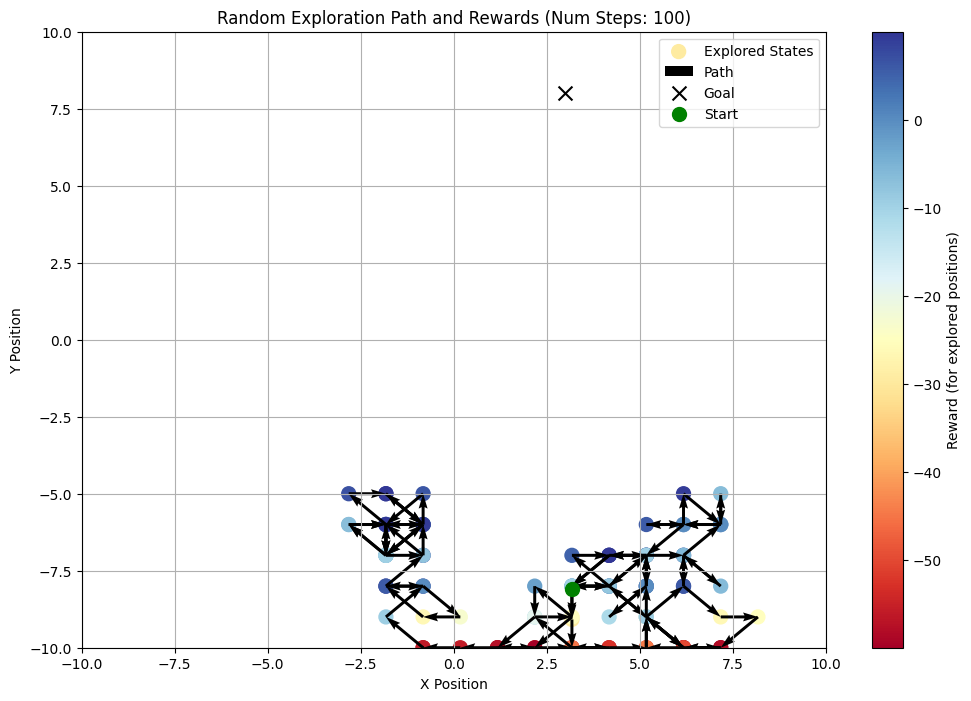

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Random exploration function
def random_exploration(starting_position, goal, boundary_limits, num_steps):
    """
    Perform random exploration starting from the given position and compute rewards.
    """
    # Possible movement directions (dx, dy)
    directions = np.array([[1, 0], [-1, 0], [0, 1], [0, -1], [1, 1], [-1, -1], [1, -1], [-1, 1]])
    
    # Initialize starting state and rewards list
    state = np.array(starting_position)
    previous_state = np.copy(state)
    rewards = []
    positions = [state]
    
    for _ in range(num_steps):
        # Randomly choose a direction to move
        movement = directions[np.random.choice(directions.shape[0])]
        
        # Update state by moving in the chosen direction
        new_state = state + movement
        
        # Ensure the agent remains within the boundary
        new_state[0] = np.clip(new_state[0], boundary_limits[0], boundary_limits[1])
        new_state[1] = np.clip(new_state[1], boundary_limits[2], boundary_limits[3])

        # Calculate reward for this movement
        reward = combined_reward(new_state, goal, previous_state, boundary_limits, max_distance_per_step=.5, max_distance=10)
        
        # Store the state and reward
        rewards.append(reward)
        positions.append(new_state)
        
        # Update previous and current states
        previous_state = state
        state = new_state

    return np.array(positions), np.array(rewards)

def plot_random_exploration():
    boundary_limits = (-10, 10, -10, 10)  # Boundary box
    goal = [3, 8]
    
    # Randomly select a starting position within the boundary limits
    starting_position = np.random.uniform(low=-9, high=9, size=2)
    
    # Perform random exploration with 100 steps
    num_steps = 100
    positions, rewards = random_exploration(starting_position, goal, boundary_limits, num_steps)
    
    # Heatmap-like scatter plot with arrows (path visualization)
    plt.figure(figsize=(12, 8))
    
    # Plot the exploration path using scatter with color based on rewards
    scatter = plt.scatter(positions[1:, 0], positions[1:, 1], c=rewards, cmap='RdYlBu', s=100, label='Explored States')
    plt.colorbar(scatter, label='Reward (for explored positions)')
    
    # Plot the arrows showing direction of movement
    U = positions[1:, 0] - positions[:-1, 0]  # X direction of movement
    V = positions[1:, 1] - positions[:-1, 1]  # Y direction of movement
    plt.quiver(positions[:-1, 0], positions[:-1, 1], U, V, scale=1, scale_units='xy', angles='xy', color='black', label='Path', width=0.004)

    # Mark the goal and starting positions
    plt.scatter(goal[0], goal[1], color='black', marker='x', s=100, label='Goal')
    plt.scatter(starting_position[0], starting_position[1], color='green', marker='o', s=100, label='Start')
    
    plt.title(f"Random Exploration Path and Rewards (Num Steps: {num_steps})")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid(True)
    plt.xlim(boundary_limits[:2])
    plt.ylim(boundary_limits[2:])
    plt.show()

# Execute the plot function to visualize random exploration
plot_random_exploration()